In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

#### Installing required libraries

* missingpy for handling missing values
* imblearn for data sampling

In [ ]:
!pip install missingpy
!pip install imblearn

     |████████████████████████████████| 51kB 1.7MB/s 


#### Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import os, shutil
import pprint
from collections import Counter
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC



from xgboost import XGBClassifier
from missingpy import MissForest
from imblearn import over_sampling, under_sampling

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Loading data

In [ ]:
DATA_PATH = 'gdrive/My Drive/Colab Notebooks/challenges/Novartis_ds/data'

train = pd.read_csv(os.path.join(DATA_PATH, 'Train.csv'))
test_df = pd.read_csv(os.path.join(DATA_PATH, 'Test.csv'))
print("We have {} rows and {} columns".format(train.shape[0], train.shape[1]))


We have 23856 rows and 18 columns


#### Target varaible distribution

1    22788
0     1068
Name: MULTIPLE_OFFENSE, dtype: int64


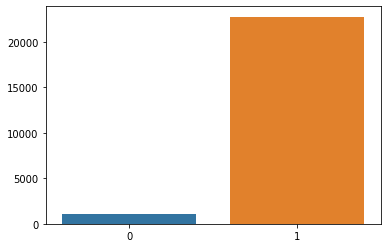

In [ ]:
# Target value distribution
target_vc = train.MULTIPLE_OFFENSE.value_counts()
pp = pprint.PrettyPrinter()
pp.pprint(target_vc)

sns.barplot(x = target_vc.index, y = target_vc.values)

The data is highly imblanced

In [ ]:
train.isna().sum()

INCIDENT_ID           0
DATE                  0
X_1                   0
X_2                   0
X_3                   0
X_4                   0
X_5                   0
X_6                   0
X_7                   0
X_8                   0
X_9                   0
X_10                  0
X_11                  0
X_12                182
X_13                  0
X_14                  0
X_15                  0
MULTIPLE_OFFENSE      0
dtype: int64

X_12 column has missing values. 

In [ ]:
train.X_12.value_counts()

1.0     15674
0.0      5171
2.0      2039
3.0       476
4.0       176
5.0        59
6.0        36
8.0         9
10.0        7
9.0         6
7.0         4
11.0        4
15.0        2
20.0        2
17.0        1
58.0        1
50.0        1
40.0        1
16.0        1
90.0        1
12.0        1
30.0        1
14.0        1
Name: X_12, dtype: int64

As the distribution is highly skewed and the proportion of missing values is very less (<1%), it is reasonable to fill missing values with mode. In this case I am using RandomForest to predict missing values 

In [ ]:
# Looking at target distribution of missing values
train[train.X_12.isna()].MULTIPLE_OFFENSE.value_counts()

1    182
Name: MULTIPLE_OFFENSE, dtype: int64

All missing values are from the majority class

In [ ]:
# Filling missing values
imputer = MissForest()
imputed_data = imputer.fit_transform(train.drop(['INCIDENT_ID', 'DATE', 'MULTIPLE_OFFENSE'], axis=1))
train['X_12'] = imputed_data[:, 11]
del imputed_data

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


#### Analyzing date variable

In [ ]:
train.DATE = pd.to_datetime(train.DATE, format='%d-%b-%y')

train['year'] = train.DATE.apply(lambda x : x.year)
train['week'] = train.DATE.apply(lambda x : x.week)
train['month'] = train.DATE.apply(lambda x : x.month)
train['day'] = train.DATE.apply(lambda x : x.day)
train['weekday'] = train.DATE.apply(lambda x : x.weekday())

In [ ]:
train.head(3)

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE,year,week,month,day,weekday
0,CR_102659,2004-07-04,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0,2004,27,7,4,6
1,CR_189752,2017-07-18,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1,2017,29,7,18,1
2,CR_184637,2017-03-15,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1,2017,11,3,15,2


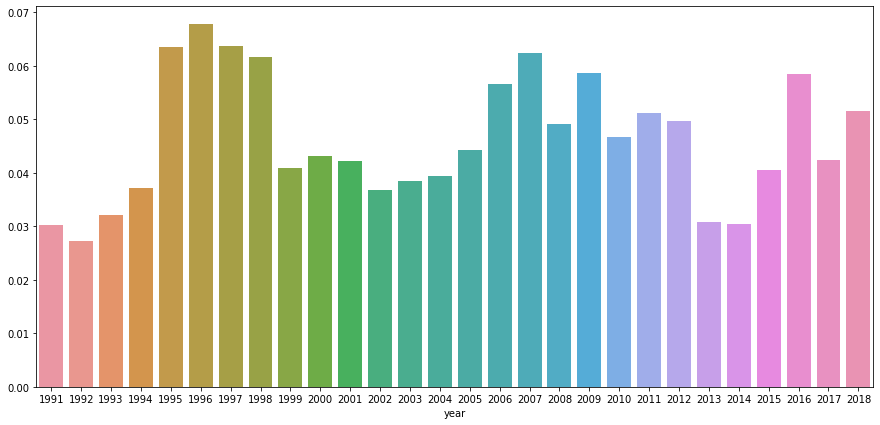

In [ ]:
# Year level target variable ratio
yearly_ratios = train[train.MULTIPLE_OFFENSE==0].groupby(['year']).INCIDENT_ID.count()/train[train.MULTIPLE_OFFENSE==1].groupby(['year']).INCIDENT_ID.count()
plt.figure(figsize=(15,7))
sns.barplot(y = yearly_ratios.values, x = yearly_ratios.index)
plt.show()

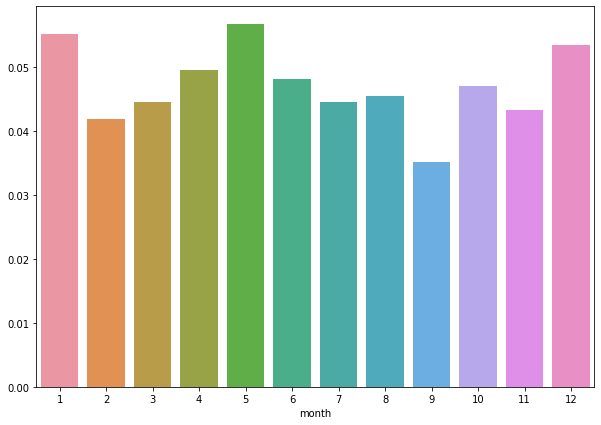

In [ ]:
month_ratios = train[train.MULTIPLE_OFFENSE==0].groupby(['month']).INCIDENT_ID.count()/train[train.MULTIPLE_OFFENSE==1].groupby(['month']).INCIDENT_ID.count()
plt.figure(figsize=(10,7))
sns.barplot(y = month_ratios.values, x = month_ratios.index)
plt.show()

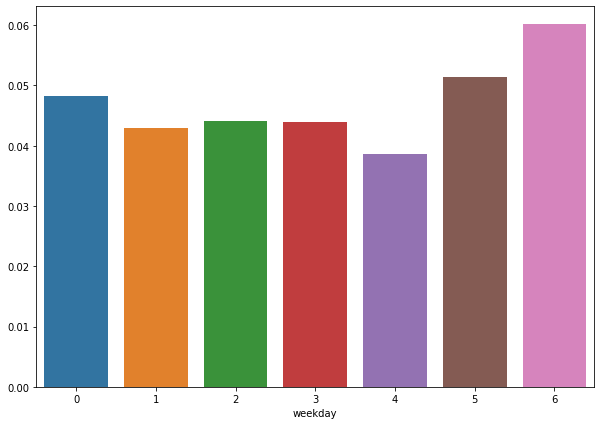

In [ ]:
weekday_ratios = train[train.MULTIPLE_OFFENSE==0].groupby(['weekday']).INCIDENT_ID.count()/train[train.MULTIPLE_OFFENSE==1].groupby(['weekday']).INCIDENT_ID.count()
plt.figure(figsize=(10,7))
sns.barplot(y = weekday_ratios.values, x = weekday_ratios.index)
plt.show()

#### Variables distribution analysis

In [ ]:
train.describe().iloc[:, :-6].T

,count,mean,std,min,25%,50%,75%,max
X_1,23856.0,0.483778,1.439738,0.0,0.0,0.0,0.0,7.0
X_2,23856.0,24.791206,15.240231,0.0,7.0,24.0,36.0,52.0
X_3,23856.0,24.637450,15.135093,0.0,8.0,24.0,35.0,52.0
X_4,23856.0,4.276744,2.944672,0.0,2.0,4.0,6.0,10.0
X_5,23856.0,2.455609,1.963095,0.0,1.0,3.0,5.0,5.0
X_6,23856.0,6.154175,4.471756,1.0,3.0,5.0,8.0,19.0
X_7,23856.0,4.876509,3.881931,0.0,2.0,4.0,7.0,18.0
X_8,23856.0,0.972460,1.453144,0.0,0.0,1.0,1.0,99.0
X_9,23856.0,4.924128,1.362625,0.0,5.0,5.0,6.0,6.0
X_10,23856.0,1.244802,1.119301,1.0,1.0,1.0,1.0,90.0


Dropping date level variables are they didn't improve the results

In [ ]:
train.drop(['INCIDENT_ID', 'DATE', 'year', 'week', 'month', 'day', 'weekday'], axis=1, inplace=True)

#### Creating all helper funcitons

Funciton to sample data to reduce the effect of imblance

In [ ]:
def data_sampling(df, over_sampling_strategy, under_sampling_strategy, target_column='MULTIPLE_OFFENSE'):
  #Over sampling and undersampling funcitons
  over = over_sampling.SMOTE(sampling_strategy=over_sampling_strategy)
  under = under_sampling.RandomUnderSampler(sampling_strategy=under_sampling_strategy)

  over_sampled_data, _ = over.fit_resample(train.values, train[target_column].values)
  sampled_data, _ = under.fit_resample(over_sampled_data, over_sampled_data[:, 15])
  #Converting sampled data to pandas dataframe
  sampled_df = pd.DataFrame(sampled_data)
  sampled_df.columns = train.columns
  return sampled_df

Function to create folds for cross validation

In [ ]:
def create_folds(df, n_folds, target_column='MULTIPLE_OFFENSE'):
  df['kFold'] = -1
  kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=18)
  for fold, (train_idxs,val_idxs) in enumerate(kfold.split(X=df, y=df[target_column].values)):
    df.loc[val_idxs, 'kFold'] = fold
  return df

Function to triain data

In [ ]:
def train_fn(df, n_folds, save_model=True, booster = 'gbtree', learning_rate = 0.1, max_depth = 3, subsample = 1, target_column='MULTIPLE_OFFENSE'):
  all_recalls = []
  if save_model:
    if not os.path.exists('models'):
      os.mkdir('models')
    else:
      shutil.rmtree('models')
      os.mkdir('models')
  for fold in range(n_folds):
    train_df = df[df.kFold.isin(FOLD_MAPPING.get(fold))]
    val_df = df[df.kFold == fold]

    train_X = train_df.drop([target_column, 'kFold'], axis=1)
    train_y = train_df[target_column].values

    val_X = val_df.drop([target_column, 'kFold'], axis=1)
    val_y = val_df[target_column].values

    #Model
    clf = XGBClassifier(booster=booster, learning_rate=learning_rate, max_depth=max_depth, subsample=subsample)
    clf.fit(train_X, train_y)
    predictions = clf.predict(val_X)
    if save_model:
      joblib.dump(clf, f"models/{algo}_{fold}.pkl")
      print(f"Saved {algo}_{fold}.pkl")
    recall = recall_score(val_y, predictions)
    all_recalls.append(recall)
    # print("Recall score  for fold {} is {}".format(fold, recall_score(val_y, predictions)))
  return all_recalls, np.mean(all_recalls)

Function to predict on test data

In [ ]:
def test(test_df):
  test_idxs = test_df.INCIDENT_ID.values
  imputer = MissForest()
  imputed_data = imputer.fit_transform(test_df.drop(['INCIDENT_ID', 'DATE'], axis=1))
  test_df['X_12'] = imputed_data[:, 11]
  del imputed_data
  test_df = test_df.drop(['INCIDENT_ID', 'DATE'], axis=1)
  predictions = pd.DataFrame()
  for fold in range(n_folds):
    clf = joblib.load(f"models/{algo}_{fold}.pkl")
    predictions[f"pred_{fold}"] = clf.predict(test_df)
  final_predictions = predictions.mode(axis=1)[0].values
  submission = pd.DataFrame({'INCIDENT_ID':test_idxs, 'MULTIPLE_OFFENSE':final_predictions})
  return submission

As this is a classification problem and with the data size we have, the choices in terms of algorithms we have are logistic regression, tree based models and SVMs. 

As there is no evident linearity and most of the features skewed, I am chose to got with tree model. In this case I am using xgboost.

In tree based models, data normalization is not needed. So, avoiding data normalization

#### Main function

In [ ]:
n_folds = 5
FOLD_MAPPING = {
    0 : [1,2,3,4],
    1 : [0,2,3,4],
    2 : [1,0,3,4],
    3 : [1,2,0,4],
    4 : [1,2,3,0],
}

parameters = {
    'over_sampling_strategy' : np.arange(0.1, 0.6, 0.1),
    'under_sampling_strategy' : np.arange(0.8, 0.4, -0.1),
    'booster' : ['gbtree', 'dart'],
    'learning_rate' : np.arange(0.1, 0.4, 0.1),
    'max_depth' : np.arange(3, 8, 1),
    'subsample' : np.arange(0.5, 1.25, 0.25)
}


#### Grid search to determine oversampling and undersampling ratios

In [ ]:
scores = []

for o in parameters['over_sampling_strategy']:
  for u in parameters['under_sampling_strategy']:
      sampled_df = data_sampling(train, o, u)
      df = create_folds(sampled_df, n_folds)
      recall_arr, recall_mean = train_fn(df, n_folds, False, 'gbtree', 0.1, 6)
      scores.append((o, u, recall_arr, recall_mean))
      print(o, u, recall_mean)

scores = sorted(scores, key=lambda x : x[3], reverse=True)
scores[0:2]

#### Grid search to determine for boosting parameters

In [ ]:
o = 0.5
u = 0.5
scores2 = []
for b in parameters['booster']:
  for lr in parameters['learning_rate']:
    for d in parameters['max_depth']:
        sampled_df = data_sampling(train, o, u)
        df = create_folds(sampled_df, n_folds)
        recall_arr, recall_mean = train_fn(df, n_folds, False, b, lr, d)
        scores2.append((b, lr, d, recall_arr, recall_mean))

scores2 = sorted(scores2, key=lambda x : x[3], reverse=True)
scores2[0:2]

#### Training and validation

In [ ]:
o = 0.5
u = 0.5
algo = 'xgb_gbtree'
sampled_df = data_sampling(train, o, u)
df = create_folds(sampled_df, n_folds)
recall_arr, recall_mean = train_fn(df, n_folds, True, booster='gbtree', learning_rate=0.2, max_depth=4)
print(recall_mean)
print(recall_arr)

Saved xgb_dart_0.pkl
Saved xgb_dart_1.pkl
Saved xgb_dart_2.pkl
Saved xgb_dart_3.pkl
Saved xgb_dart_4.pkl
0.9995611917996827
[0.9997806055287407, 0.999341816586222, 0.9995611147684881, 1.0, 0.9991224221149627]


In [ ]:
os.listdir('models')

['xgb_dart_2.pkl',
 'xgb_dart_1.pkl',
 'xgb_dart_4.pkl',
 'xgb_dart_0.pkl',
 'xgb_dart_3.pkl']

#### Predicting on the test data

In [ ]:
submission = test(test_df)
submission.to_csv(f"{algo}.csv", index=False)  
files.download(f"{algo}.csv")